In [1476]:
!pip install pyspark==3.1.2

In [1477]:
import pyspark

In [1478]:
import pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()
spark

### Data Cleaning Process:

#### a) Read Data

In [1479]:
import pyspark 
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()
SD=spark.read.csv("Suicide Rates Overview 1985 to 2016_new.csv",header=True,inferSchema=True)
SD.show(5)

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------------+------------------+---------------+
|country|year|   sex|        age|suicides_no|population|suicides/100k pop|HDI for year| gdp_for_year ($) |gdp_per_capita ($)|     generation|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------------+------------------+---------------+
|Albania|1987|  male|15-24 years|         21|    312900|             6.71|        null|       2.1566249E9|               796|   Generation X|
|Albania|1987|  male|35-54 years|         16|    308000|             5.19|        null|       2.1566249E9|               796|         Silent|
|Albania|1987|female|15-24 years|         14|    289700|             4.83|        null|       2.1566249E9|               796|   Generation X|
|Albania|1987|  male|  75+ years|          1|     21800|             4.59|        null|       2.1566249E9|               796|G.I. Generation|
|Alban

#### b) Rename Columns & Datatype

In [1480]:
SD.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicides/100k pop: double (nullable = true)
 |-- HDI for year: double (nullable = true)
 |--  gdp_for_year ($) : double (nullable = true)
 |-- gdp_per_capita ($): integer (nullable = true)
 |-- generation: string (nullable = true)



In [1481]:
CSD=SD.withColumnRenamed("suicides/100k pop","suicide_100k_pop")\
             .withColumnRenamed("HDI for year","HDI_for_year")\
             .withColumnRenamed(" gdp_for_year ($) ","gdp_for_year")\
             .withColumnRenamed("gdp_per_capita ($)","gdp_for_capita")
CSD.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- HDI_for_year: double (nullable = true)
 |-- gdp_for_year: double (nullable = true)
 |-- gdp_for_capita: integer (nullable = true)
 |-- generation: string (nullable = true)



In [1498]:
from pyspark.sql.functions import *
DCSD=CSD.withColumn("gdp_for_year",CSD["gdp_for_year"].cast('float'))

####  c)Check Duplicates

In [1660]:
DCSD.count()
CCSD=DCSD.dropDuplicates()
CCSD.count()

27820

27820

## Checking Null values

In [1502]:
MCSD=DCSD.select([count(when(col(c).isNull(), c)).alias(c) for c in DCSD.columns])
MCSD.show()

+-------+----+---+---+-----------+----------+----------------+------------+------------+--------------+----------+
|country|year|sex|age|suicides_no|population|suicide_100k_pop|HDI_for_year|gdp_for_year|gdp_for_capita|generation|
+-------+----+---+---+-----------+----------+----------------+------------+------------+--------------+----------+
|      0|   0|  0|  0|          0|         0|               0|       19456|           0|             0|         0|
+-------+----+---+---+-----------+----------+----------------+------------+------------+--------------+----------+



In [1512]:
NCSD=DCSD.drop('HDI_for_year')
NCSD.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- gdp_for_year: float (nullable = true)
 |-- gdp_for_capita: integer (nullable = true)
 |-- generation: string (nullable = true)



In [1513]:
NCSD.describe().show(truncate=False)

+-------+----------+------------------+------+-----------+------------------+------------------+------------------+---------------------+------------------+----------+
|summary|country   |year              |sex   |age        |suicides_no       |population        |suicide_100k_pop  |gdp_for_year         |gdp_for_capita    |generation|
+-------+----------+------------------+------+-----------+------------------+------------------+------------------+---------------------+------------------+----------+
|count  |27820     |27820             |27820 |27820      |27820             |27820             |27820             |27820                |27820             |27820     |
|mean   |null      |2001.2583752695903|null  |null       |242.57440690150972|1844793.6173975556|12.816097411933894|4.455809464126039E11 |16866.464414090584|null      |
|stddev |null      |8.469055024441408 |null  |null       |902.0479168336403 |3911779.4417563565|18.96151101450326 |1.4536096942677644E12|18887.576472205576|null

In [1515]:
NCSD.select("country").distinct().count()

101

In [1570]:
A=NCSD.select("country","suicide_100k_pop").groupBy("country").sum()
A.sort("sum(suicide_100k_pop)",ascending=False).show(5)

+------------------+---------------------+
|           country|sum(suicide_100k_pop)|
+------------------+---------------------+
|Russian Federation|   11305.130000000006|
|         Lithuania|   10588.879999999997|
|           Hungary|   10156.069999999994|
|        Kazakhstan|    9519.519999999995|
| Republic of Korea|    9350.449999999995|
+------------------+---------------------+
only showing top 5 rows



### Data Visualization

In [1571]:
G=NCSD.select(["year",'sex','suicide_100k_pop']).groupBy("sex","year").sum()
G.select("sex","sum(suicide_100k_pop)","year").sort("year",ascending=True).show(5)

+------+---------------------+----+
|   sex|sum(suicide_100k_pop)|year|
+------+---------------------+----+
|female|   1663.7499999999993|1985|
|  male|    5148.139999999999|1985|
|  male|    4905.789999999998|1986|
|female|    1674.049999999999|1986|
|female|   1857.2099999999991|1987|
+------+---------------------+----+
only showing top 5 rows



In [ ]:
NCSD.select("")

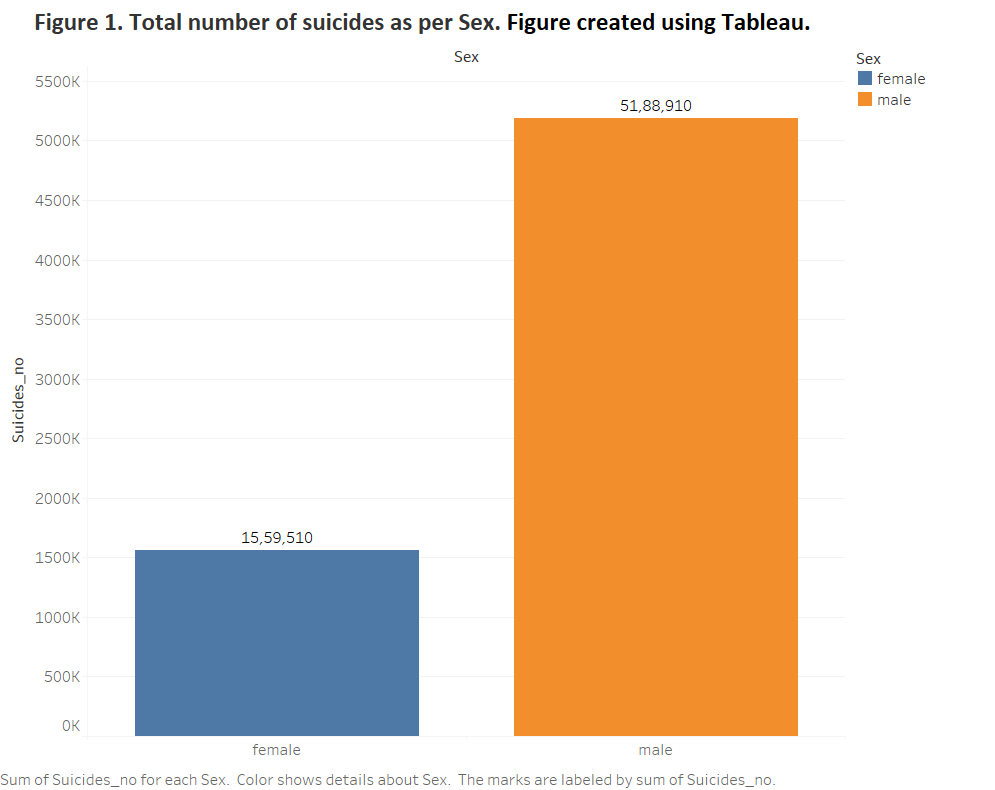

In [1543]:
NCSD.select(['age','suicides_no']).groupBy("age").sum()

+-----------+----------------+
|        age|sum(suicides_no)|
+-----------+----------------+
|55-74 years|         1658443|
|25-34 years|         1123912|
| 5-14 years|           52264|
|  75+ years|          653118|
|15-24 years|          808542|
|35-54 years|         2452141|
+-----------+----------------+



In [1573]:
age=NCSD.select(['age','suicide_100k_pop']).groupBy("age").sum()
age.sort("sum(suicide_100k_pop)",ascending=False).show()

+-----------+---------------------+
|        age|sum(suicide_100k_pop)|
+-----------+---------------------+
|  75+ years|   111201.01000000008|
|55-74 years|    74994.20000000007|
|35-54 years|    69386.01999999999|
|25-34 years|   56571.520000000055|
|15-24 years|    41532.69000000003|
| 5-14 years|    2858.389999999998|
+-----------+---------------------+



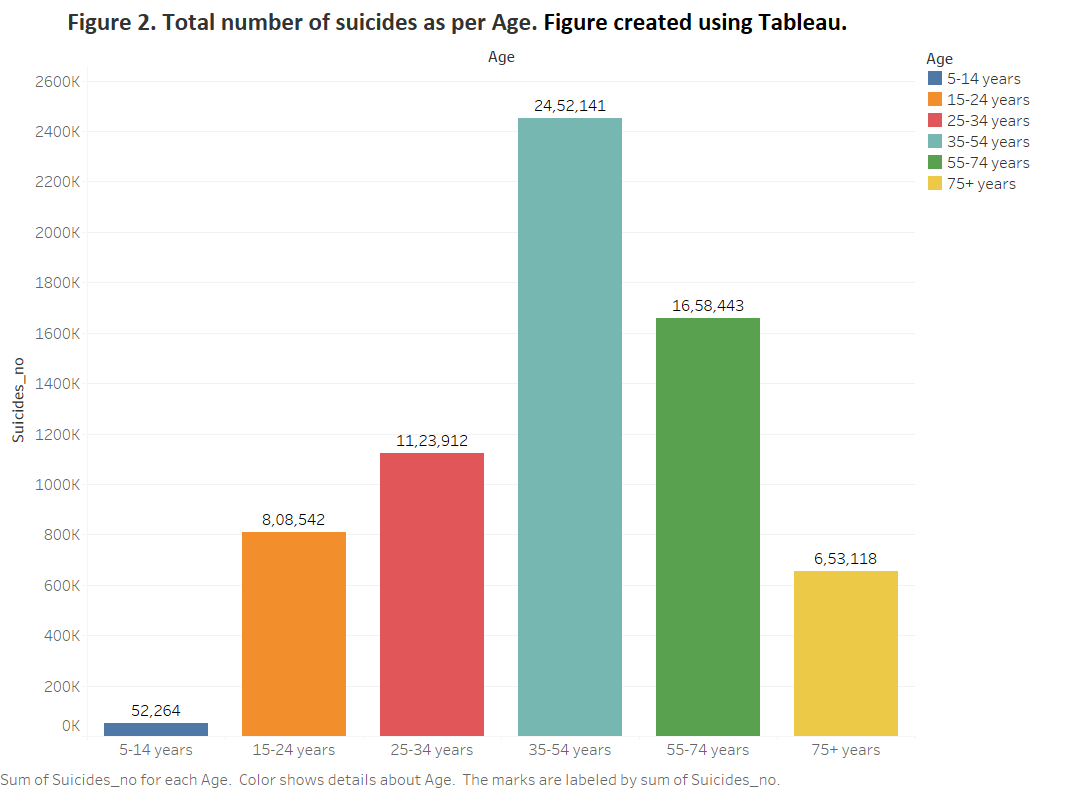

In [1009]:
NCSD.select(['year','suicides_no'])

DataFrame[year: int, suicides_no: int]

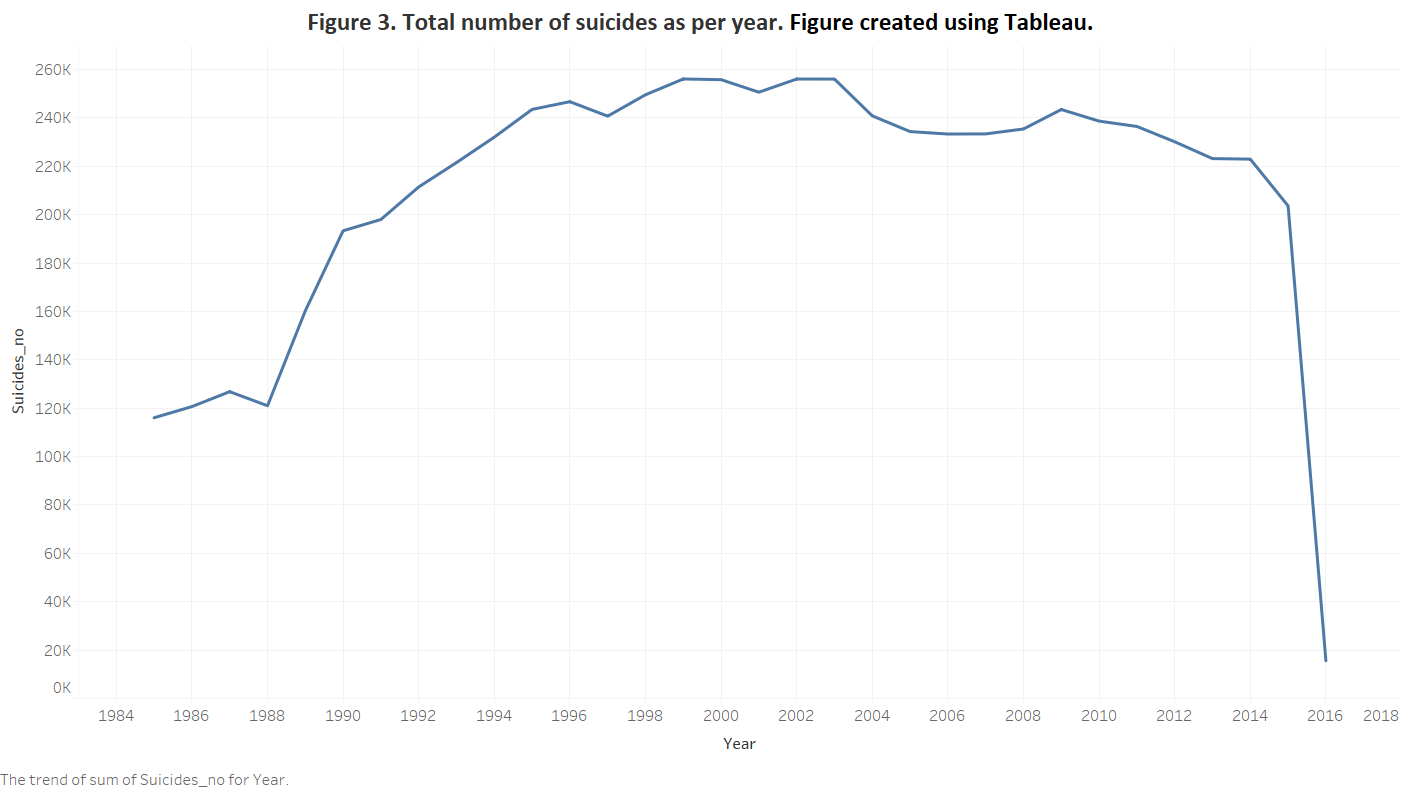

In [1569]:

A=NCSD.select(['year','country','suicides_no'])
# print(NCSD.corr("suicides_no","gdp_for_capita"))
# print(NCSD_index.corr("suicides_no","sex_index"))
# print(NCSD_index.corr("suicides_no","age_index"))
# print(NCSD_index.corr("suicides_no","generation_index"))
# print(NCSD_index.corr("suicides_no","population"))
# print(NCSD_index.corr("suicides_no","suicide_100k_pop"))
# print(NCSD_index.corr("suicides_no","gdp_for_capita"))
# print(NCSD_index.corr("suicides_no","country_index"))
# print(NCSD_index.corr("suicides_no","gdp_for_year"))
# NCSD_index.corr()

TypeError: corr() missing 2 required positional arguments: 'col1' and 'col2'

In [1564]:
AB=NCSD.select('country','suicides_no','gdp_for_capita').groupBy('country').sum()
AB.sort("sum(suicides_no)",ascending=False).show(10)

+------------------+----------------+-------------------+
|           country|sum(suicides_no)|sum(gdp_for_capita)|
+------------------+----------------+-------------------+
|Russian Federation|         1209742|            2112096|
|     United States|         1034013|           14608296|
|             Japan|          806902|           13539888|
|            France|          329127|           11333328|
|           Ukraine|          319950|             627492|
|           Germany|          291262|           10971240|
| Republic of Korea|          261730|            5506068|
|            Brazil|          226613|            2266032|
|            Poland|          139098|            2346180|
|    United Kingdom|          136805|           11869908|
+------------------+----------------+-------------------+
only showing top 10 rows



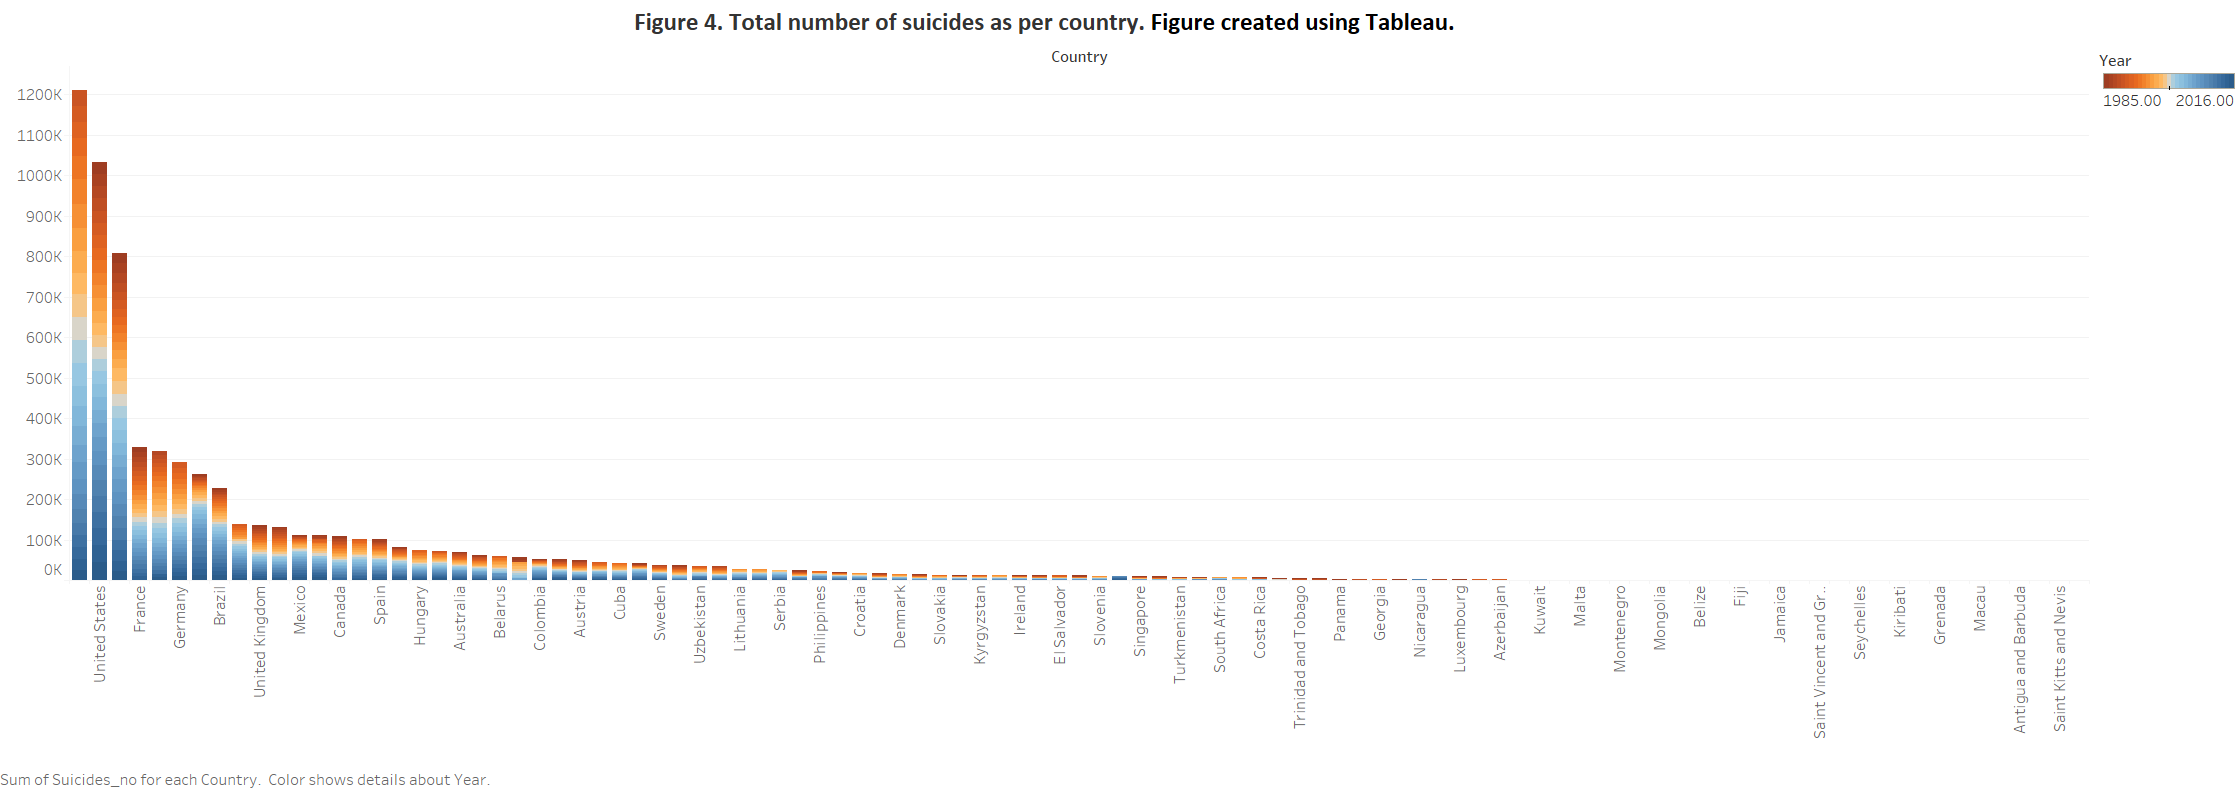

## Machine Learning Models
### >>Predicting total number of suicides by Linear Reggression model

In [1012]:
NCSD.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- gdp_for_year: float (nullable = true)
 |-- gdp_for_capita: integer (nullable = true)
 |-- generation: string (nullable = true)



In [1312]:
from pyspark.ml.feature import StringIndexer
cat_num=StringIndexer(inputCols=["country","sex","age","generation"],
                      outputCols=["country_index","sex_index","age_index","generation_index"])
NCSD_index=cat_num.fit(NCSD).transform(NCSD)
NCSD_index.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- gdp_for_year: float (nullable = true)
 |-- gdp_for_capita: integer (nullable = true)
 |-- generation: string (nullable = true)
 |-- country_index: double (nullable = false)
 |-- sex_index: double (nullable = false)
 |-- age_index: double (nullable = false)
 |-- generation_index: double (nullable = false)



In [1662]:
from pyspark.ml.feature import VectorAssembler
featureassembler=VectorAssembler(inputCols=['population','suicide_100k_pop','gdp_for_capita',
                                            'sex_index','age_index','generation_index'],
                                            outputCol='features')
output=featureassembler.transform(NCSD_index)
final_data=output.select('features','suicides_no').show(5)

+--------------------+-----------+
|            features|suicides_no|
+--------------------+-----------+
|[177400.0,5.64,12...|         10|
|[206286.0,11.15,1...|         23|
|[6084.0,0.0,10468...|          0|
|[385400.0,0.52,38...|          2|
|[1465721.0,6.55,2...|         96|
+--------------------+-----------+
only showing top 5 rows



In [1606]:
from pyspark.ml.feature import StandardScaler
scaler=StandardScaler(inputCol='features',outputCol='scaled_features',
                      withStd=True,withMean=False)
scaled_model=scaler.fit(final_data)
lin_data=scaled_model.transform(final_data)
fin_lin_data=lin_data.select("suicides_no","scaled_features")


In [1612]:
from pyspark.ml.regression import LinearRegression
train_data,test_data=fin_lin_data.randomSplit([0.7,0.3])
lin=LinearRegression(featuresCol='scaled_features',labelCol='suicides_no')
lin_reg=lin.fit(train_data)

In [1613]:
lin_summary=lin_reg.summary
print("Linear Regression RMSE= %.2f" % lin_summary.rootMeanSquaredError)
print("Linear Regression r2= %.2f" %lin_summary.r2)

Linear Regression RMSE= 664.12
Linear Regression r2= 0.47


### Decision Tree Regression

In [1388]:
from pyspark.ml.regression import DecisionTreeRegressor
dec=DecisionTreeRegressor(featuresCol='scaled_features',labelCol='suicides_no')
dec_reg=dec.fit(train_data)
dec_final=dec_reg.transform(train_data)

In [1424]:
from pyspark.ml.evaluation import RegressionEvaluator
dec_eval_r2=RegressionEvaluator(labelCol='suicides_no',predictionCol='prediction',metricName='r2')
r2_dec=dec_eval_r2.evaluate(dec_final)
dec_eval_rmse=RegressionEvaluator(labelCol='suicides_no',predictionCol='prediction',metricName='rmse')
rmse_dec=dec_eval_rmse.evaluate(dec_final)
dec_eval_mae=RegressionEvaluator(labelCol='suicides_no',predictionCol='prediction',metricName='mae')
mae_dec=dec_eval_mae.evaluate(dec_final)

print("Decision Tree Regression r2=%.2f" %r2_dec)
print("Decision Tree Regression RMSE=%.2f" %rmse_dec)
print("Decision Tree Regression mae=%.2f" %mae_dec)

Decision Tree Regression r2=0.95
Decision Tree Regression RMSE=211.71
Decision Tree Regression mae=69.15


## Random Forest Regression

In [1421]:
from pyspark.ml.regression import RandomForestRegressor
ran=RandomForestRegressor(featuresCol='scaled_features',labelCol='suicides_no')
ran_reg=ran.fit(train_data)
ran_final=ran_reg.transform(train_data)

In [1425]:
ran_eval_r2=RegressionEvaluator(labelCol='suicides_no',predictionCol='prediction',metricName='r2')
r2_ran=ran_eval_r2.evaluate(ran_final)
ran_eval_rmse=RegressionEvaluator(labelCol='suicides_no',predictionCol='prediction',metricName='rmse')
rmse_ran=ran_eval_rmse.evaluate(ran_final)
ran_eval_mae=RegressionEvaluator(labelCol='suicides_no',predictionCol='prediction',metricName='mae')
mae_ran=ran_eval_mae.evaluate(ran_final)

print("Random Forest Regression r2=%.2f" %r2_ran)
print("Random Forest Regression RMSE=%.2f" %rmse_ran)
print("Random Forest Regression mae=%.2f" %mae_ran)

Random Forest Regression r2=0.82
Random Forest Regression RMSE=381.27
Random Forest Regression mae=114.68


## Gradient Boosted Tree Regression

In [1430]:
from pyspark.ml.regression import GBTRegressor
gbt=GBTRegressor(featuresCol='scaled_features',labelCol='suicides_no')
gbt_reg=gbt.fit(train_data)
gbt_final=gbt_reg.transform(train_data)

In [1427]:
gbt_eval_r2=RegressionEvaluator(labelCol='suicides_no',predictionCol='prediction',metricName='r2')
r2_gbt=gbt_eval_r2.evaluate(gbt_final)
gbt_eval_rmse=RegressionEvaluator(labelCol='suicides_no',predictionCol='prediction',metricName='rmse')
rmse_gbt=gbt_eval_rmse.evaluate(gbt_final)
gbt_eval_mae=RegressionEvaluator(labelCol='suicides_no',predictionCol='prediction',metricName='mae')
mae_gbt=gbt_eval_mae.evaluate(gbt_final)

print("Gradient Boosted Tree Regression r2=%.2f" %r2_gbt)
print("Gradient Boosted Tree Regression RMSE=%.2f" %rmse_gbt)
print("Gradient Boosted Tree Regression mae=%.2f" %mae_gbt)

Gradient Boosted Tree Regression r2=0.98
Gradient Boosted Tree Regression RMSE=139.61
Gradient Boosted Tree Regression mae=39.98


## K Means Clustering model

In [1051]:
NCSD_index.describe()

DataFrame[summary: string, country: string, year: string, sex: string, age: string, suicides_no: string, population: string, suicide_100k_pop: string, gdp_for_year: string, gdp_for_capita: string, generation: string, country_index: string, sex_index: string, age_index: string, generation_index: string]

In [1052]:
NCSD_index.columns

['country',
 'year',
 'sex',
 'age',
 'suicides_no',
 'population',
 'suicide_100k_pop',
 'gdp_for_year',
 'gdp_for_capita',
 'generation',
 'country_index',
 'sex_index',
 'age_index',
 'generation_index']

In [1435]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
vec_assembler=VectorAssembler(inputCols=["suicides_no","population",'suicide_100k_pop',"gdp_for_capita",
                                        'country_index','sex_index','age_index','generation_index'],outputCol='clus_features')
output_data=vec_assembler.transform(NCSD_index)

### Scaling Data

In [1436]:
from pyspark.ml.feature import StandardScaler
scaler=StandardScaler(inputCol='clus_features',outputCol='clus_scaled_features',withStd=True,withMean=False)
scaled_model=scaler.fit(output_data)
cluster_data=scaled_model.transform(output_data)

In [1437]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
eval_model=ClusteringEvaluator(predictionCol="prediction",featuresCol='clus_scaled_features',
                              metricName='silhouette',distanceMeasure='squaredEuclidean')

In [1438]:
# silhouette_score=[]
print(""" Silhouette Score for k Mean Clustering
==========================================
Model\tScore\t
=====\t=====\t""") 
for k in range(2,11):
    kmeans=KMeans(featuresCol='clus_scaled_features',k=k)
    kmeans_fit=kmeans.fit(cluster_data)
    final_data=kmeans_fit.transform(cluster_data)
    score=eval_model.evaluate(final_data)
#     silhouette_score.append(score)
    print("K=",k,"\t",score,"\t")

 Silhouette Score for k Mean Clustering
Model	Score	
=====	=====	
K= 2 	 0.23044922043506058 	
K= 3 	 0.18251790521343167 	
K= 4 	 0.20159108306819562 	
K= 5 	 0.25716451288939984 	
K= 6 	 0.26436989889004076 	
K= 7 	 0.28181745942654746 	
K= 8 	 0.28772092069916644 	
K= 9 	 0.2760273036768222 	
K= 10 	 0.2818515831357536 	


## Classification Models

In [1614]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
vec_assembler=VectorAssembler(inputCols=["year","suicides_no","population",'suicide_100k_pop',
                                         "gdp_for_year","gdp_for_capita",
                                        'country_index','age_index','generation_index'],
                              outputCol='class_features')
class_output_data=vec_assembler.transform(NCSD_index)

In [1664]:
from pyspark.ml.feature import StandardScaler
class_scaler=StandardScaler(inputCol='class_features',outputCol='scaled_class_features',
                            withStd=True,withMean=False)
class_scaled_model=class_scaler.fit(class_output_data)
cm_data=class_scaled_model.transform(class_output_data)
class_data=cm_data.select('scaled_class_features','sex_index')
class_train,class_test=class_data.randomSplit([0.7,0.3])
class_train.show(5)

Exception ignored in: <function JavaModelWrapper.__del__ at 0x000002815850CEE0>
Traceback (most recent call last):
  File "C:\Users\pagid\anaconda3\lib\site-packages\pyspark\mllib\common.py", line 137, in __del__
    self._sc._gateway.detach(self._java_model)
AttributeError: 'BinaryClassificationMetrics' object has no attribute '_sc'
Exception ignored in: <function JavaModelWrapper.__del__ at 0x000002815850CEE0>
Traceback (most recent call last):
  File "C:\Users\pagid\anaconda3\lib\site-packages\pyspark\mllib\common.py", line 137, in __del__
    self._sc._gateway.detach(self._java_model)
AttributeError: 'BinaryClassificationMetrics' object has no attribute '_sc'
Exception ignored in: <function JavaModelWrapper.__del__ at 0x000002815850CEE0>
Traceback (most recent call last):
  File "C:\Users\pagid\anaconda3\lib\site-packages\pyspark\mllib\common.py", line 137, in __del__
    self._sc._gateway.detach(self._java_model)
AttributeError: 'BinaryClassificationMetrics' object has no attribut

+---------------------+---------+
|scaled_class_features|sex_index|
+---------------------+---------+
| [234.382701998199...|      0.0|
| [234.382701998199...|      0.0|
| [234.500778926157...|      0.0|
| [234.736932782075...|      1.0|
| [234.736932782075...|      1.0|
+---------------------+---------+
only showing top 5 rows



## Logistic Regression

In [1639]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [1640]:
log_reg=LogisticRegression(labelCol='sex_index',featuresCol='scaled_class_features',maxIter=40)
log_model=log_reg.fit(class_train)

In [1641]:
log_prediction=log_model.transform(class_test)

In [1642]:
eval_lr=MulticlassClassificationEvaluator(labelCol="sex_index",predictionCol="prediction",
                                          metricName="accuracy")
lr_accuracy=eval_lr.evaluate(log_prediction)
print("Logistic Regression accuracy= %.2f" %lr_accuracy)

Logistic Regression accuracy= 0.71


## Random Forest

In [1209]:
ran_for=RandomForestClassifier(labelCol='sex_index',featuresCol='scaled_class_features',numTrees=40)
ran_model=ran_for.fit(class_train)

In [1210]:
ran_prediction=ran_model.transform(class_test)

In [1413]:
eval_ran=MulticlassClassificationEvaluator(labelCol="sex_index",predictionCol="prediction",
                                           metricName="accuracy")
ran_accuracy=eval_ran.evaluate(ran_prediction)
print("Random Forest accuracy= %.2f" %ran_accuracy)


Random Forest accuracy= 0.73


In [1213]:
ran_model.featureImportances

SparseVector(9, {0: 0.0021, 1: 0.1176, 2: 0.0363, 3: 0.7099, 4: 0.0163, 5: 0.0062, 6: 0.0263, 7: 0.0743, 8: 0.0109})

## Decision Tree Classifier

In [1214]:
decision_class= DecisionTreeClassifier(labelCol='sex_index',featuresCol='scaled_class_features')
decision_model=decision_class.fit(class_train)

In [1215]:
decision_prediction=decision_model.transform(class_test)

In [1414]:
eval_decision=MulticlassClassificationEvaluator(labelCol="sex_index",predictionCol="prediction",
                                                metricName="accuracy")
decision_accuracy=eval_decision.evaluate(decision_prediction)
print("Decision Tree accuracy= %.2f" %decision_accuracy)

Decision Tree accuracy= 0.76


In [1217]:
decision_model.featureImportances

SparseVector(9, {1: 0.0038, 2: 0.0201, 3: 0.7636, 4: 0.0002, 5: 0.0025, 6: 0.0809, 7: 0.1289})

## Naive Bayes

In [1218]:
naive_bayes=NaiveBayes(labelCol='sex_index',featuresCol='scaled_class_features',smoothing=1.0)
naive_model=naive_bayes.fit(class_train)

In [1219]:
naive_prediction=naive_model.transform(class_test)

In [1415]:
eval_naive=MulticlassClassificationEvaluator(labelCol="sex_index",predictionCol="prediction",
                                             metricName="accuracy")
naive_accuracy=eval_naive.evaluate(naive_prediction)
print("Naive Bayes accuracy= %.2f" %naive_accuracy)

Naive Bayes accuracy= 0.71


In [1659]:
from platform import python_version

print(python_version())

3.9.7
